<a href="https://colab.research.google.com/github/bhkpriyanka/EVA4/blob/master/Week5/MODEL1_Setup_%26_SkeletalCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TARGET:**  
1.create end-to-end setup and fully functional basic code skeleton.  
2.Normalize dataset,define data transformations after visualizing data shape and distribution.  
3.Create dataloaders and set test and train loops

**RESULTS:**  
*#params:*  89664  
*best train acc:* 99.21  
*best test acc:* 99.15

**ANALYSIS:**  
1.Model is quiet heavy in terms of no. of parameters.  
2.The gap between train accuracy and the test accuracy is high most of the times i.e., model is overfitting.


**IMPORT LIBRARIES**

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

**MEAN & SD CALCULATION FOR NORMALIZING DATASET**

In [2]:
# simple transform for entire dataset
import numpy as np
simple_transforms = transforms.Compose([
                                        transforms.ToTensor(),
                                      ])
exp = datasets.MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_traindata = exp.train_data
exp_traindata_np = exp.transform(exp_traindata.numpy())
exp_testdata = exp.test_data
exp_testdata_np = exp.transform(exp_testdata.numpy())
#exp_data = torch.cat((exp_traindata,exp_testdata), 0)
exp_data_np = np.stack((exp_traindata_np,exp_testdata_np), axis=0)

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', np.min(exp_data_np))
print(' - max:', np.max(exp_data_np))
print(' - mean:', np.mean(exp_data_np))
print(' - std:', np.std(exp_data_np))
print(' - var:', np.var(exp_data_np))

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:60: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: 0.0
 - max: 1.0
 - mean: 0.13066061
 - std: 0.30810952
 - var: 0.09493148


**DEFINE TRAIN & TEST DATA TRANSFORMATIONS**

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) 
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


**IMPORT DATA AND SPLIT INTO TRAIN AND TEST**

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

**DEFINING DATALOADER ARGS AND CREATING TEST & TRAIN DATALOADERS**

In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


**LOOKING AT IMAGE SAMPLE**

torch.Size([128, 1, 28, 28])
torch.Size([128])


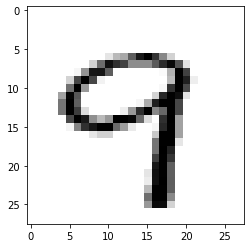

In [6]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

**LOOKING AT SOME MORE IMAGES**

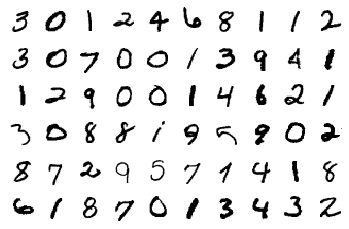

In [7]:
#TO FIGURE OUT IMAGE AUGMENTATION STRATEGIES NEEDED LATER
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

**MODEL DEFINITION**

In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
            
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()
            
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()            
            
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()           
           
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU()            
            
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=100, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU()          
            
        ) # output_size = 6
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=100, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            
        ) 

        
    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)        
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

**MODEL SUMMARY**

In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
            Conv2d-3           [-1, 32, 24, 24]           4,608
              ReLU-4           [-1, 32, 24, 24]               0
            Conv2d-5           [-1, 10, 24, 24]             320
         MaxPool2d-6           [-1, 10, 12, 12]               0
            Conv2d-7           [-1, 20, 10, 10]           1,800
              ReLU-8           [-1, 20, 10, 10]               0
            Conv2d-9             [-1, 32, 8, 8]           5,760
             ReLU-10             [-1, 32, 8, 8]               0
           Conv2d-11             [-1, 64, 6, 6]          18,432
             ReLU-12             [-1, 64, 6, 6]               0
           Conv2d-13            [-1, 100, 6, 6]          57,600
             ReLU-14            [-

**WRITING TRAIN AND TEST FUNCTIONS**

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

**TRAINING AND TESTING THE MODEL**

In [11]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=2.302467107772827 Batch_id=468 Accuracy=10.99: 100%|██████████| 469/469 [00:09<00:00, 47.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.3021, Accuracy: 974/10000 (9.74%)

EPOCH: 1


Loss=2.2995870113372803 Batch_id=468 Accuracy=11.70: 100%|██████████| 469/469 [00:09<00:00, 48.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 2.2984, Accuracy: 1282/10000 (12.82%)

EPOCH: 2


Loss=0.275231271982193 Batch_id=468 Accuracy=48.78: 100%|██████████| 469/469 [00:09<00:00, 48.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3014, Accuracy: 9072/10000 (90.72%)

EPOCH: 3


Loss=0.09147423505783081 Batch_id=468 Accuracy=94.61: 100%|██████████| 469/469 [00:09<00:00, 47.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1105, Accuracy: 9658/10000 (96.58%)

EPOCH: 4


Loss=0.07779335975646973 Batch_id=468 Accuracy=96.98: 100%|██████████| 469/469 [00:10<00:00, 45.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0794, Accuracy: 9746/10000 (97.46%)

EPOCH: 5


Loss=0.05202610790729523 Batch_id=468 Accuracy=97.61: 100%|██████████| 469/469 [00:09<00:00, 48.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0472, Accuracy: 9854/10000 (98.54%)

EPOCH: 6


Loss=0.022567197680473328 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:09<00:00, 47.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0418, Accuracy: 9860/10000 (98.60%)

EPOCH: 7


Loss=0.028238752856850624 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:09<00:00, 47.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0358, Accuracy: 9882/10000 (98.82%)

EPOCH: 8


Loss=0.015676042065024376 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:09<00:00, 47.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0364, Accuracy: 9895/10000 (98.95%)

EPOCH: 9


Loss=0.08387544006109238 Batch_id=468 Accuracy=98.80: 100%|██████████| 469/469 [00:10<00:00, 45.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9910/10000 (99.10%)

EPOCH: 10


Loss=0.0073745050467550755 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:09<00:00, 47.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9906/10000 (99.06%)

EPOCH: 11


Loss=0.012476627714931965 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:09<00:00, 48.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0355, Accuracy: 9884/10000 (98.84%)

EPOCH: 12


Loss=0.04786286875605583 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:09<00:00, 48.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0337, Accuracy: 9898/10000 (98.98%)

EPOCH: 13


Loss=0.0064407289028167725 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:09<00:00, 48.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9905/10000 (99.05%)

EPOCH: 14


Loss=0.01571367122232914 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:10<00:00, 46.42it/s]



Test set: Average loss: 0.0265, Accuracy: 9915/10000 (99.15%)



**VISUALIZING TRAIN,TEST LOSSES & ACCURACIES**

Text(0.5, 1.0, 'Test Accuracy')

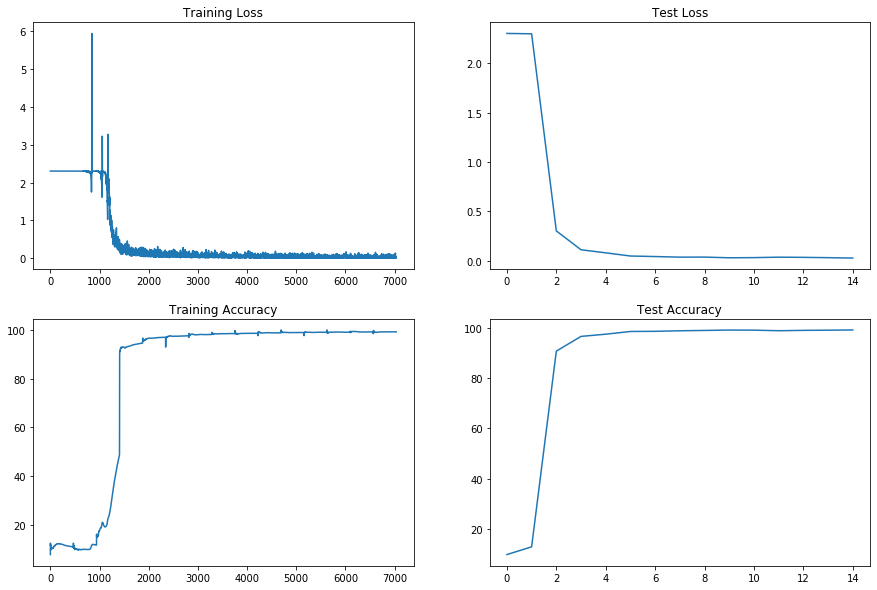

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")